$
\newcommand{\Tau}{\mathcal{T}}
\newcommand{\bm}[1]{{\boldsymbol{#1}}}
\newcommand{\dt}[1]{{\frac{d#1}{dt}}}
%\newcommand{\bm}{\mathbf{#1}}
\newcommand{\trsp}{{\scriptscriptstyle\top}}$

In [1]:
import numpy as np
import pbdlib as pbd
import matplotlib.pyplot as plt
from scipy.stats import wishart
%matplotlib inline

In [2]:
def sample_wishart(mu_0, kappa, T, nu, nb_samples=10):
    lmbda = wishart.rvs(nu, T, size=(nb_samples,))
    mu = np.array([
        np.random.multivariate_normal(mu_0, np.linalg.inv(kappa * l))
          for l in lmbda])
    gmm = pbd.GMM(nb_dim=mu_0.shape[0], nb_states=nb_samples)
    gmm.mu, gmm.lmbda = mu, lmbda
    gmm.priors = np.ones(nb_samples)/nb_samples
    return gmm

def sample_wishart_posterior(x, mu_0, kappa, T, nu, nb_samples=10):
    n = x.shape[0]
    m_x = np.mean(x, axis=0)
    mu_n = (kappa * mu_0 + n * m_x)/(kappa + n)
    S = np.einsum('ai,aj->ij', x - m_x[None], x - m_x[None])
    T_n_1 = np.linalg.inv(T) + S + (kappa * nu)/(kappa + nu)* np.einsum('i,j->ij',
                                                      mu_0 - m_x, mu_0-m_x)
    T_n = np.linalg.inv(T_n_1)
    nu_n = nu + n
    kappa_n = kappa + n
    
    return sample_wishart(mu_n, kappa_n, T_n, nu_n, nb_samples=nb_samples)


In [3]:
figsize = (15, 8)

# Bayesian GMM conditioning and applications to policy imitation 

## Bayesian statistics gentle reminder


<img  src="img/random_sure.jpg"/>

Inference about parameters $\bm{\theta}$ given observation $\bm{x}$

\begin{align}
	 \mathrm{observation} &\quad \bm{x} &\quad \{\mathrm{NINE}, \mathrm{NINE}, \mathrm{NINE}\} \\
	 \mathrm{parameters} &\quad \bm{\theta} &\quad \{\mathrm{RANDOM},\mathrm{NOT\ RANDOM}\} \\
\end{align}

#### Maximum likelihood 

\begin{align}
	 \mathrm{likelihood\ function} \quad p(\bm{x}|\bm{\theta})\\
	 \hat{\bm{\theta}}_{ML} = \arg\max_{\bm{\theta}}(p(\bm{x}|\bm{\theta}))
\end{align}

#### Maximum a posteriori 

\begin{align}
	p(\bm{\theta}|\bm{x}) = \frac{p(\bm{x}|\bm{\theta}) p(\bm{\theta})}{p(\bm{x})}
\end{align}

\begin{align}
	\hat{\bm{\theta}}_{MAP} &= \arg\max_{\bm{\theta}}(p(\bm{\theta}|\bm{x}))\\
	 &= \arg\max_{\bm{\theta}}(p(\bm{x}|\bm{\theta})p(\bm{\theta}))\\
\end{align}

#### Approximating posterior
- MCMC: Sampling from $p(\bm{\theta}|\bm{x})$
- Variational inference: Approximating $p(\bm{\theta}|\bm{x})$ with $q(\bm{\theta})$
- Exact computation: conjugate prior, discrete
    


A prior is called a conjugate prior if the posterior distribution is of the same family for a likelihood function. The prior can be interpreted as having observed some *pseudo-observations*, that would be added to the true ones.

## Gaussian example with Normal Wishart Prior 

/home/agrolegion/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


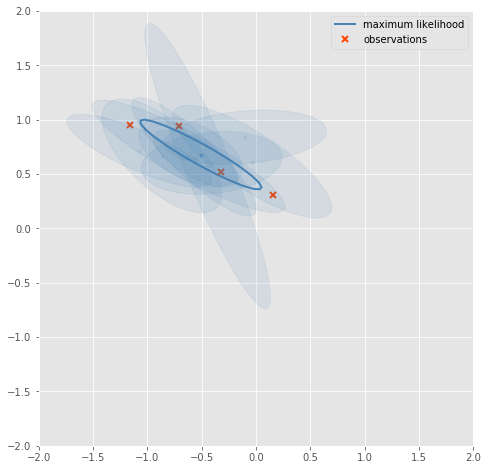

In [4]:
plt.figure(figsize=(8, 8))
import matplotlib.patches as mpatches
nu = 2.

cov = np.array([[1., -0.95], [-0.95, 1.]])
x_1 = np.random.multivariate_normal(np.zeros(2), 0.4 * cov, (4, ))

cov_ml = np.cov(x_1.T)
mu_ml = np.mean(x_1, axis=0)

sample_wishart_posterior(
    x_1, np.zeros(2), .1, 5. * np.eye(2)/nu, nu).plot(
    alpha=0.1, color='steelblue')

pbd.plot_gaussian(mu_ml, cov_ml, color='steelblue', lw=2, label='maximum likelihood')
plt.plot(x_1[:, 0], x_1[:, 1], 'kx', color='orangered', mew=2, ms=6, label='observations')
plt.legend()

plt.axes().set_aspect('equal')
plt.xlim([-2., 2.])
plt.ylim([-2., 2.]);

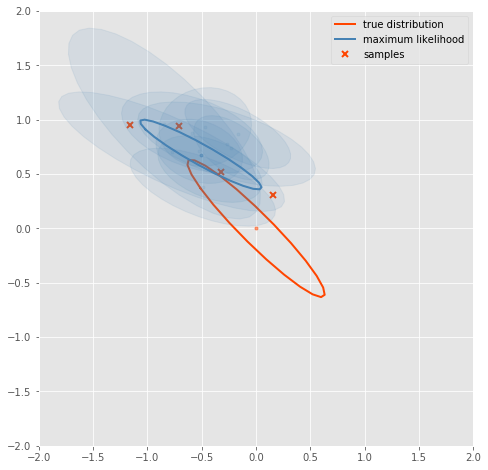

In [5]:
plt.figure(figsize=(8, 8))

nu = 2.

cov = np.array([[1., -0.95], [-0.95, 1.]])

cov_ml = np.cov(x_1.T)
mu_ml = np.mean(x_1, axis=0)

sample_wishart_posterior(
    x_1, np.zeros(2), .1, 5. * np.eye(2)/nu, nu).plot(
    alpha=0.1, color='steelblue')

pbd.plot_gaussian(np.zeros(2), 0.4 * cov, color='orangered', lw=2, label='true distribution')
pbd.plot_gaussian(mu_ml, cov_ml, color='steelblue', lw=2, label='maximum likelihood')
plt.plot(x_1[:, 0], x_1[:, 1], 'kx', color='orangered', mew=2, ms=6, label='samples')

plt.legend()

plt.axes().set_aspect('equal')
plt.xlim([-2., 2.])
plt.ylim([-2., 2.]);

## Gaussian example with Normal Wishart Prior 

### Prior distribution 

conjugate prior $p(\bm{\theta})$ of Gaussian likelihood

\begin{align}
	p(\bm{\mu}, \bm{\Lambda}) &= \mathcal{NW}(\bm{\mu}, \bm{\Lambda}|\,\bm{\mu}_0, \kappa, \nu, \bm{T})\\
	&= \mathcal{N}(\bm{\mu}|\,\bm{\mu}_0, (\kappa\bm{\Lambda})^{-1})\mathcal{W}_{\nu}(\bm{\Lambda}|\bm{T})
\end{align}

\begin{align}
	\mathrm{location} &\quad\bm{\mu}_0\\ 
	\mathrm{location\ precision} &\quad\kappa\\
	\mathrm{degree\ of\ freedom} &\quad\nu\\
	\mathrm{scale\ matrix} &\quad\bm{T}_0 
\end{align}

mode $(\nu − d − 1)\bm{T}$

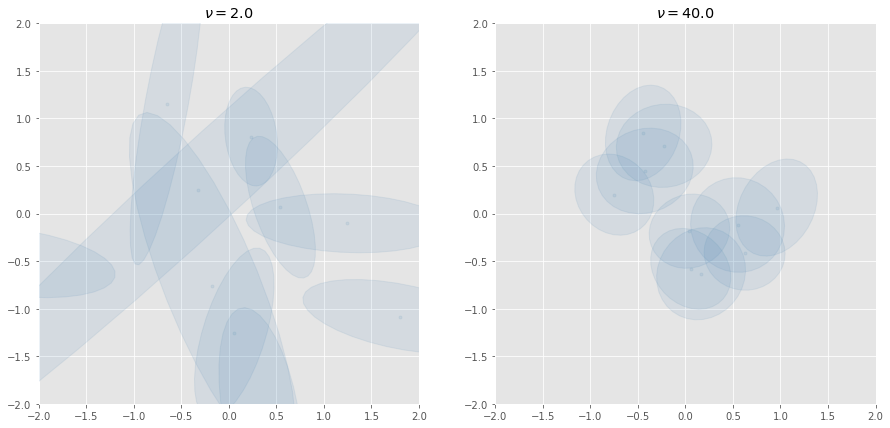

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=figsize)

nus = [2., 40.]

for i, nu in enumerate(nus):
    sample_wishart(
        np.zeros(2), .5, 5. * np.eye(2)/nu, nu).plot(
        alpha=0.1, ax=ax[i], color='steelblue')
    
    ax[i].set_title(r'$\nu=%.1f$' % nu)

[a.set_aspect('equal') for a in ax]
[a.set_xlim([-2., 2.]) for a in ax]
[a.set_ylim([-2., 2.]) for a in ax];


### Posterior distribution 

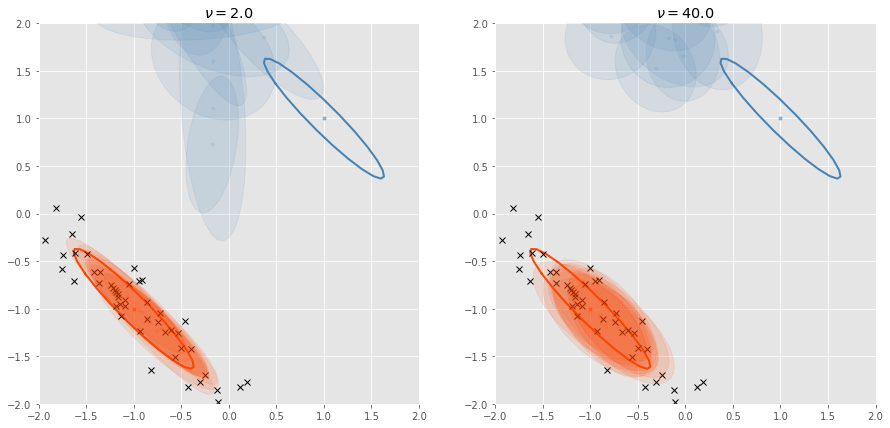

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=figsize)

nus = [2., 40.]

cov = np.array([[1., -0.95], [-0.95, 1.]])
x_1 = np.random.multivariate_normal(np.ones(2), 0.4 * cov, (2, ))
x_2 = np.random.multivariate_normal(-np.ones(2), 0.4 * cov, (50, ))

for i, nu in enumerate(nus):
    sample_wishart_posterior(
        x_1, np.zeros(2), .1, 5. * np.eye(2)/nu, nu).plot(
        alpha=0.1, ax=ax[i], color='steelblue')
    sample_wishart_posterior(
        x_2, np.zeros(2), .1, 5. * np.eye(2)/nu, nu).plot(
        alpha=0.1, ax=ax[i], color='orangered')
    
    pbd.plot_gaussian(np.ones(2), 0.4 * cov, ax=ax[i], color='steelblue', lw=2)
    pbd.plot_gaussian(-np.ones(2), 0.4 * cov, ax=ax[i], color='orangered', lw=2)
    ax[i].plot(x_1[:, 0], x_1[:, 1], 'kx')
    ax[i].plot(x_2[:, 0], x_2[:, 1], 'kx')
    ax[i].set_title(r'$\nu=%.1f$' % nu)

[a.set_aspect('equal') for a in ax]
[a.set_xlim([-2., 2.]) for a in ax]
[a.set_ylim([-2., 2.]) for a in ax];


posterior $p(\bm{\theta}|\bm{X}) = \frac{p(\bm{X}|\bm{\theta}) p(\bm{\theta})}{p(\bm{X})}$
\begin{align}
p(\bm{\mu}, \bm{\Lambda}|\bm{X}) &= \mathcal{N}(\bm{\mu}|\bm{\mu}_n, (\kappa_n\bm{\Lambda}_n)^{-1})\mathcal{W}_{\nu_n}(\bm{\Lambda}_n|\bm{T}_n)\\
\bm{\mu}_n &= \frac{\kappa\bm{\mu}_0 + n\bar{\bm{x}}}{\kappa + n}\\
\bm{T}_n^{-1} &= \bm{T}^{-1} + \bm{S} + \frac{\kappa n}{\kappa + n}(\bm{\mu}_0 - \bar{\bm{x}}) (\bm{\mu}_0 - \bar{\bm{x}})^T\\
\bm{S} &= \sum_{i=1}^{n}(\bm{x}_i - \bar{\bm{x}})(\bm{x}_i - \bar{\bm{x}})^T\\
\nu_n &= \nu + n\\
\kappa_n &= \kappa + n\\
\end{align}

A bit biased when too strong priors

### Posterior predictive distribution 

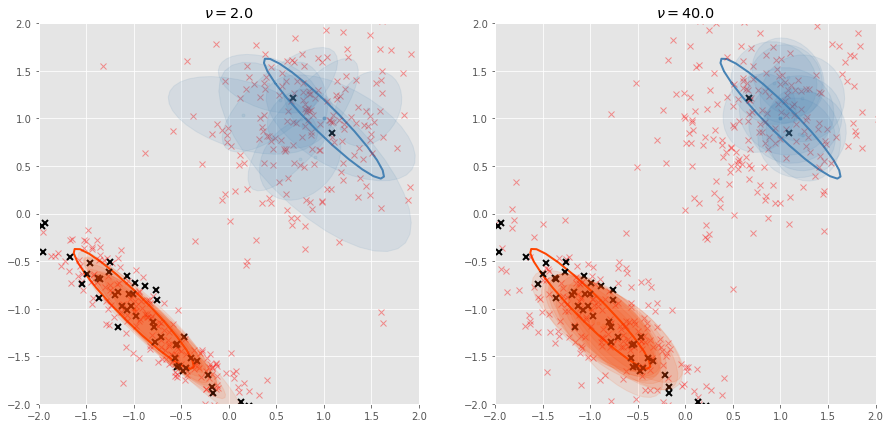

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=figsize)

nus = [2., 40.]

cov = np.array([[1., -0.95], [-0.95, 1.]])
x_1 = np.random.multivariate_normal(np.ones(2), 0.4 * cov, (2, ))
x_2 = np.random.multivariate_normal(-np.ones(2), 0.4 * cov, (50, ))

for i, nu in enumerate(nus):
    sample_wishart_posterior(
        x_1, np.zeros(2), .1, 5. * np.eye(2)/nu, nu).plot(
        alpha=0.1, ax=ax[i], color='steelblue')
    sample_wishart_posterior(
        x_2, np.zeros(2), .1, 5. * np.eye(2)/nu, nu).plot(
        alpha=0.1, ax=ax[i], color='orangered')
    
    x_1_pred = sample_wishart_posterior(x_1, np.zeros(2), .1, 5. * np.eye(2)/nu, nu, 200).sample(200)
    x_2_pred = sample_wishart_posterior(x_2, np.zeros(2), .1, 5. * np.eye(2)/nu, nu, 200).sample(200)
    
    pbd.plot_gaussian(np.ones(2), 0.4 * cov, ax=ax[i], color='steelblue', lw=2)
    pbd.plot_gaussian(-np.ones(2), 0.4 * cov, ax=ax[i], color='orangered', lw=2)
    ax[i].plot(x_1_pred[:, 0], x_1_pred[:, 1], 'rx',alpha=0.4)
    ax[i].plot(x_2_pred[:, 0], x_2_pred[:, 1], 'rx',alpha=0.4)
    
    ax[i].plot(x_1[:, 0], x_1[:, 1], 'kx', ms=6, mew=2)
    ax[i].plot(x_2[:, 0], x_2[:, 1], 'kx', ms=6, mew=2)
    ax[i].set_title(r'$\nu=%.1f$' % nu)

[a.set_aspect('equal') for a in ax]
[a.set_xlim([-2., 2.]) for a in ax]
[a.set_ylim([-2., 2.]) for a in ax];


posterior predictive $p(\bm{x}|\bm{X}) = \int_{\bm{\theta}} p(\bm{x}| \bm{\theta})p(\bm{\theta}|\bm{X})d\bm{\theta}$

\begin{align}
	p(\bm{x}|\bm{X}) = t_{\nu_n - d + 1}(\bm{\mu}_n, \frac{\bm{T}_n(\kappa_n + 1)}{\kappa_n(\nu_n - d + 1)})
\end{align}

### Multivariate t-distribution 

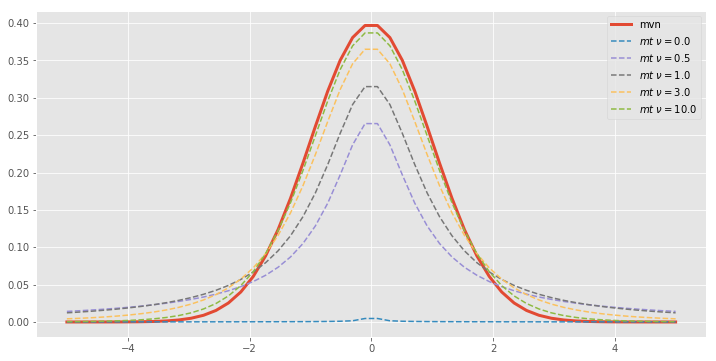

In [9]:
plt.figure(figsize=(12, 6))
x = np.linspace(-5., 5.)

mvn_pdf = np.exp(pbd.functions.multi_variate_normal(x, np.zeros(1), np.eye(1)))

plt.plot(x, mvn_pdf, label='mvn', lw=3)

for nu in [0.001, 0.5, 1., 3., 10.]:
    mt_pdf = np.exp(pbd.functions.multi_variate_t(x, nu, np.zeros(1), np.eye(1)))
    plt.plot(x, mt_pdf, label=r'$mt\ \nu=%.1f$'%nu, ls='--')
    
plt.legend();

## Conditioning 

In [10]:
joint_model = pbd.VBayesianGMM({'n_components':1, 'n_init':10, 'reg_covar': 0.01 ** 2,
         'covariance_prior': 1. ** 2 * np.eye(2),'mean_precision_prior':1e-9, 'degrees_of_freedom_prior': 1.3,
                               'weight_concentration_prior_type':'dirichlet_distribution',})

In [11]:
def plot_conditional(x_1, figsize=(15, 15)):
    
    cov = np.array([[1., -0.99], [-0.99, 1.]])
    

    joint_model.posterior(data=x_1)

    joint_model.make_posterior_samples(nb_samples=10)

    x_in_test = np.linspace(-10., 10., 100)[:, None]

    x_pred, x_pred_cov = joint_model.condition(x_in_test, slice(0, 1), slice(1, 2))
    x_pred_s, x_pred_cov_s, mus_pred = joint_model.condition(x_in_test, slice(0, 1), slice(1, 2),
                                                   samples=True, return_samples=True)

    mus = np.array([m.mu[0] for m in joint_model._posterior_samples])
    sigmas = np.array([m.sigma[0] for m in joint_model._posterior_samples])

    plt.figure(figsize=figsize)
    pbd.plot_y_gaussian(x_in_test, x_pred, x_pred_cov, dim=0, color='steelblue')
    plt.xlim([x_in_test[0], x_in_test[-1]])
    plt.ylim([-10., 10.])
    for mu in mus_pred:
        plt.plot(x_in_test, mu, 'r--', alpha=0.3, color='steelblue')

    pbd.plot_gmm(mus, sigmas, alpha=0.1, border=True, color='orangered')
    plt.plot(x_1[:, 0], x_1[:, 1], 'kx')
    plt.xlabel(r'$x_{in}$')
    plt.ylabel(r'$x_{out}$')

In [12]:
plot_conditional(np.random.multivariate_normal(np.zeros(2), 0.4 * cov, (100, )), figsize=(10, 10))

TypeError: super() takes at least 1 argument (0 given)

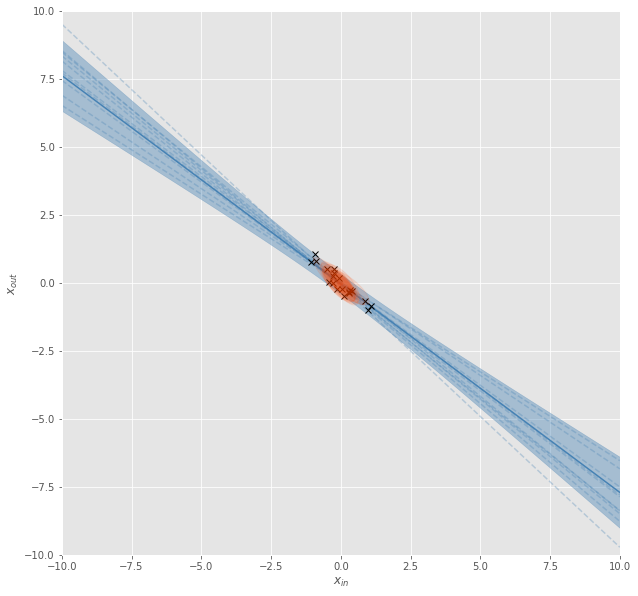

In [18]:
plot_conditional(np.random.multivariate_normal(np.zeros(2), 0.4 * cov, (20, )), figsize=(10, 10))

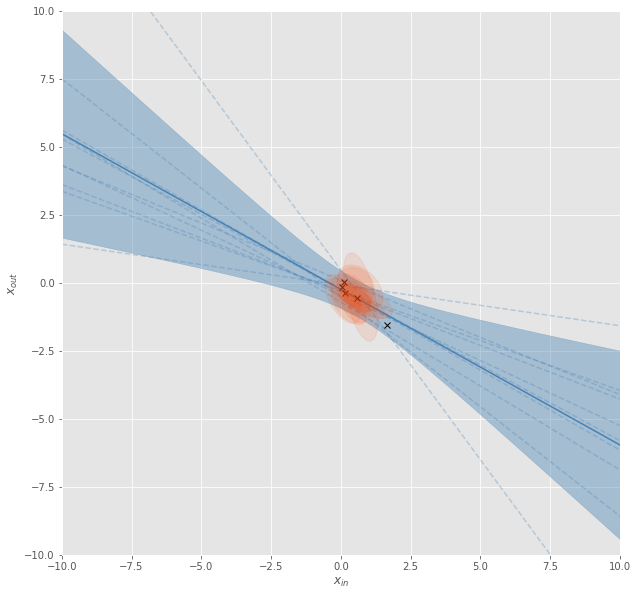

In [19]:
plot_conditional(np.random.multivariate_normal(np.zeros(2), 0.4 * cov, (5, )), figsize=(10, 10))

### Multivariate normal
\begin{align}
	\bm{\mu}_{1|2} &= \bm{\mu}_1 + \bm{\Sigma}_{12}\bm{\Sigma}_{22}^{-1}(\bm{x}_2-\bm{\mu}_2)\\
	\bm{\Sigma}_{1|2} &= \bm{\Sigma}_{11}-\bm{\Sigma}_{12}\bm{\Sigma}_{22}^{-1}\bm{\Sigma}_{12}^T
\end{align}

### Multivariate t-distribution

\begin{align}
\nu_{1|2} &= \nu + d_2\\
\bm{\mu}_{1|2} &= \bm{\mu}_1 + \bm{\Sigma}_{12}\bm{\Sigma}_{22}^{-1}(\bm{x}_2-\bm{\mu}_2)\\
\bm{\Sigma}_{1|2} &= \frac{\nu + (\bm{x}_2-\bm{\mu}_2)^T\bm{\Sigma}_{22}^{-1}(\bm{x}_2-\bm{\mu}_2)}{\nu + d_2}(\bm{\Sigma}_{11}-\bm{\Sigma}_{12}\bm{\Sigma}_{22}^{-1}\bm{\Sigma}_{12}^T)
\end{align}

## Regression

Policy $p(\bm{u}_t|\,\bm{x}_t)$

System dynamics $p(\bm{x}_{t+1}|\,\bm{x}_t, \bm{u}_t)$

## Same but with a mixture

One linear trend is not expressive enough.

Training same as EM, alternate between computing posterior of Gaussian given responsabilities and compute responsabilities given posterior distribution.  (see *Pattern Recognition and Machine Learning, Bishop*)
- much less sensitive to initialization (covariance, cluster can disappear and appear) 
- posterior predictive distribution is a mixture of **Multivariate t-distribution**

Conditioning same as with one distribution but have to compute probability of belonging to a cluster given input point.

Dirichlet process, nice addition. New point have probability to be assign to an existing cluster or to a new one according to some *density* parameter $\alpha$. Good for:
- online learning: add new observation without destroying everything
- uncertainty: when query conditional, always probability to be in a new state
- automatic selection of the number of cluster, but be **very cautious**

<img  width=600 src="img/joint_distribution_freq.png"/>

<img width=600 src="img/joint_distribution.png"/>

### Comparison Bayesian and frequentist 

<img  src="img/bayes_vs_freq_004.png"/>

<img  src="img/bayes_vs_freq_003.png"/>

<img  src="img/bayes_vs_freq_002.png"/>

<img  src="img/bayes_vs_freq_001.png"/>

## Application to policy imitation

hard problem
- integrating the policy could lead to catastrophic deviations
- errors due to modeling, perturbations, uncertainties  

### Typical problems 
Even with the simplest possible setup

<img  src="img/freq_policy_001.png"/>

<img  src="img/freq_policy_002.png"/>

## Why going Bayesian 

### Uncertainty quantification 

<img width=400 src="img/bayes_policy_uncertainty_001.png"/>

<img width=400 src="img/bayes_policy_uncertainty_002.png"/>

<img width=400 src="img/bayes_policy_uncertainty_003.png"/>

### Prior knowledge 

<img  src="img/bayes_policy_prior_001.png"/>

<img  src="img/bayes_policy_prior_002.png"/>

### Fusion of knowledge 

Fusion of multiple controllers. Position, velocity and force. 

Setup:
- two controllers $p_1(\bm{x})$, $p_2(\dot{\bm{x}}|\,\bm{x})$
- fusing the controllers at the actual controller level (velocity), have to solve a easy optimal control problem to transform $p_1(\bm{x})$ in $p_1(\dot{\bm{x}})$. Done here using LQR with a local approximation of the mixture $p_1(\bm{x})$ by a Gaussian.

<img  src="img/fusion_001.png"/>

<img  src="img/fusion_002.png"/>

Setup:
- two controllers $p_1(\bm{x}|\,\mathrm{end})$, $p_2(\dot{\bm{x}}|\,\bm{x})$, up to a certain time, the robot should have attain the end-state distribution
- LQR with cost on $\bm{x}$ only at the end and cost on $\bm{u}$ always to match marginal distribution of command

In [13]:
%%html
<video width='480' height='480' controls>
    <source src='img/policy_001_dp_gmm_lqr.mp4'>
    Your browser does not support the video tag.
</video>

In [21]:
%%html
<video width='480' height='480' controls>
    <source src='img/policy_002_dp_gmm_lqr.mp4'>
    Your browser does not support the video tag.
</video>

In [22]:
%%html
<video width='480' height='480' controls>
    <source src='img/policy_003_dp_gmm_lqr.mp4'>
    Your browser does not support the video tag.
</video>